Mean Squared Error:  0.01044671615445682
Mean Absolute Error:  0.06450685055458914
Root Mean Squared Error:  0.10220917842570118
R2 Score:  0.7962118103336198


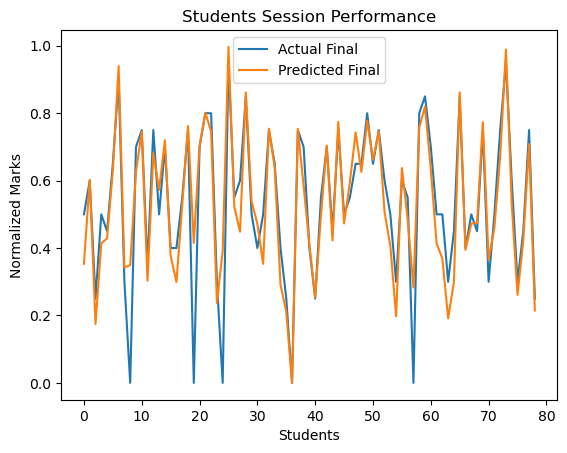

    Actual Final  Predicted Final  Percentage Predicted Grade
0             10                7   38.333333               F
1             12               12   63.333333               C
2              5                3   18.333333               F
3             10                8   41.666667               F
4              9                9   45.000000               F
..           ...              ...         ...             ...
74            12               11   56.666667              D+
75             6                5   30.000000               F
76             9                8   43.333333               F
77            15               14   71.666667              B-
78             5                4   25.000000               F

[79 rows x 4 columns]


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def predict_grade(percentage):
    if percentage >= 90:
        return 'A+'
    elif percentage >= 86:
        return 'A'
    elif percentage >= 82:
        return 'A-'
    elif percentage >= 78:
        return 'B+'
    elif percentage >= 74:
        return 'B'
    elif percentage >= 70:
        return 'B-'
    elif percentage >= 66:
        return 'C+'
    elif percentage >= 62:
        return 'C'
    elif percentage >= 58:
        return 'C-'
    elif percentage >= 54:
        return 'D+'
    elif percentage >= 50:
        return 'D'
    else:
        return 'F'

def process_studentsdata():
    df = pd.read_csv("student-mat.csv")
    
    #assigning student id's 
    student_ids = ['Std' + str(i+1) for i in range(len(df))]
    df.insert(0, 'StudentID', student_ids)
    
    unnecessary_columns = ['address', 'school', 'Mjob', 'Fjob', 'Medu', 'Fedu', 'famsize', 'reason', 'guardian', 'failures'
                          ,'nursery', 'sex', 'famsup', 'traveltime', 'Pstatus', 'age', 'romantic', 'goout', 'schoolsup', 
                          'studytime', 'paid', 'health', 'freetime' , 'activities', 'higher', 'famrel', 'internet', 'Dalc'
                          ,'Walc']
    
    #removing unnecessary columns
    df.drop(unnecessary_columns, axis=1, inplace = True)
 
    #renaming columns
    df = df.rename(columns = {'G1': 'Mid1', 'G2': 'Mid2', 'G3': 'Final'})
    mid1_min = df['Mid1'].min()
    mid1_max = df['Mid1'].max()
    mid2_min = df['Mid2'].min()
    mid2_max = df['Mid2'].max()
    min_value = df['Final'].min()
    max_value = df['Final'].max()

    #assigning grades based on percentage
    #assuming Mid1, Mid2, Final are out of 20 marks (60 marks total)
    df['Percentage'] = ((df['Mid1'] + df['Mid2'] + df['Final']) / 60) * 100
    df['Final_Grade'] = ''
    for i in range(len(df)):
        percentage = df.loc[i, 'Percentage']
        if percentage >=90:
            df.loc[i, 'Final_Grade'] = 'A+'
        elif percentage >= 86:
            df.loc[i, 'Final_Grade'] = 'A'
        elif percentage >= 82:
            df.loc[i, 'Final_Grade'] = 'A-'        
        elif percentage >= 78:
            df.loc[i, 'Final_Grade'] = 'B+'        
        elif percentage >= 74:
            df.loc[i, 'Final_Grade'] = 'B'        
        elif percentage >= 70:
            df.loc[i, 'Final_Grade'] = 'B-'        
        elif percentage >= 66:
            df.loc[i, 'Final_Grade'] = 'C+'        
        elif percentage >= 62:
            df.loc[i, 'Final_Grade'] = 'C'        
        elif percentage >= 58:
            df.loc[i, 'Final_Grade'] = 'C-'  
        elif percentage >= 54:
            df.loc[i, 'Final_Grade'] = 'D+'  
        elif percentage >= 50:
            df.loc[i, 'Final_Grade'] = 'D'      
        else:
            df.loc[i, 'Final_Grade'] = 'F'    
    

    #Convert grades into numerical variables by applying one hot encoding on grades
    grades = ['A+', 'A-', 'A', 'B+', 'B', 'B-', 'C+', 'C', 'C-', 'D+', 'D', 'F']
    one_hot = pd.get_dummies(df['Final_Grade'])
    one_hot = one_hot.reindex(columns = grades, fill_value=0)
    df.drop('Final_Grade', axis=1, inplace=True)
    df = pd.concat([df, one_hot], axis=1)
    
    #replacing absence column with Attendance%
    df.drop('Percentage', axis=1, inplace=True)
    #assuming max absences can be 100
    df['Attendance%'] = (1 - (df['absences'] / 100)) * 100
    df.drop('absences', axis=1, inplace=True)
    
    #normalising numerical variables so that attendance%, mid1, mid2, final and grades all contain values between 0 and 1
    columns_to_normalize = ['Attendance%', 'Mid1', 'Mid2', 'Final']
    #MinMaxScaler function scales the data between 0 and 1
    scaler = MinMaxScaler()
    df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

    #saving the data in updated file
    df.to_csv('Students_Updated_Dataset.csv', index = False)
    return mid1_min, mid1_max, mid2_min, mid2_max, min_value, max_value
    
mid1_min, mid1_max, mid2_min, mid2_max, min_value, max_value = process_studentsdata()

df = pd.read_csv('Students_Updated_Dataset.csv')

X = df[['Mid1', 'Mid2', 'Attendance%']]
y = df['Final']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

y_pred = np.clip(model.predict(X_test), 0, 20)
y_pred = np.clip(y_pred, 0, 20)

#Calculating the mean squared error, mean absolute error, and R2 score to assess the performance of the regression model.
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('Mean Squared Error: ', mse)
print('Mean Absolute Error: ', mae)
print('Root Mean Squared Error: ', rmse)
print('R2 Score: ', r2)

plt.plot(y_test.values, label = 'Actual Final')
plt.plot(y_pred, label = 'Predicted Final')
plt.xlabel('Students')
plt.ylabel('Normalized Marks')
plt.title('Students Session Performance')
plt.legend()
plt.show()

test_results = pd.DataFrame({'Actual Final': y_test.values, 'Predicted Final': y_pred})
mylist = y_test.index.tolist()

#inverse normalization
for i in range(len(y_test.values)):
    y_test.values[i] = round(y_test.values[i] * (max_value - min_value) + min_value)
    y_pred[i] = round(y_pred[i] * (max_value - min_value) + min_value)
    test_results.at[i, 'Actual Final'] = y_test.values[i]
    test_results.at[i, 'Predicted Final'] = y_pred[i]

test_results['Percentage'] = 0.0
for j in range(len(y_test.values)):
    test_results['Percentage'].values[j] = (df.loc[mylist[j], 'Mid1'] * (mid1_max - mid1_min) + mid1_min + df.loc[mylist[j], 'Mid2'] * (mid2_max - mid2_min) + mid2_min + test_results['Predicted Final'].values[j])/60 * 100
    test_results['Predicted Grade'] = test_results['Percentage'].apply(predict_grade)

cols = ["Actual Final", "Predicted Final"]
test_results[cols] = test_results[cols].astype(int)

print(test_results)
import pickle

# Save the trained model to a file
with open('my_model.pkl', 'wb') as f:
    pickle.dump(model, f)


Note: you may need to restart the kernel to use updated packages.
